In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from util.parse_worker import df_worker_valid, df_worker_GPU, df_worker_jobs

font = {
    "family": "Times New Roman",
    'size': 18
}

matplotlib.rc('font', **font)

df = pd.read_csv('../data/worker.csv')
df.head()

,id,job_name,worker_name,replica_type,host_ip,gmt_created,gmt_pod_running,gmt_pod_finished,RES
0,28613,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-master-0,master,8bd29cd3a6c570901c5ce23aa0a5557266068fc370e1e4...,2023/7/15 00:47,NaN,2023/7/15 00:49,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/..."
1,28614,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-0,worker,46547b40034dea27dff7a94dee665d3804b7869286d00d...,2023/7/15 00:47,NaN,2023/7/15 00:49,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/..."
2,28615,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-1,worker,47b54b963095fc8211922de281e8a1306783c9809d8ca6...,2023/7/15 00:47,NaN,2023/7/15 00:49,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/..."
3,28616,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-2,worker,7acd990b9db2ffb8b982727c3463746e7c25e0f215c28f...,2023/7/15 00:47,NaN,2023/7/15 00:49,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/..."
4,28617,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-3,worker,2d1f3f74639b00279140135610e4d4cce920754951735f...,2023/7/15 00:47,NaN,2023/7/15 00:49,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/..."


Valid jobs / total jobs: 4276/5294 (80.77%)


Text(0.5, 1.0, 'valid jobs: 80.77%')

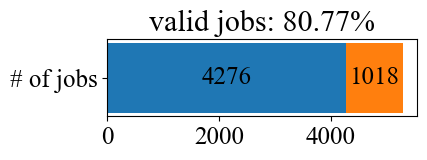

In [2]:
num_jobs = len(df['job_name'].unique())
num_valid_jobs = len(df_worker_valid['job_name'].unique())
print(f"Valid jobs / total jobs: {num_valid_jobs}/{num_jobs} ({num_valid_jobs/num_jobs*100:.2f}%)")

fig, ax = plt.subplots(figsize=(4, 1))
b = ax.barh(["# of jobs"], [num_valid_jobs])
ax.bar_label(b, label_type="center")
b = ax.barh(["# of jobs"], [num_jobs - num_valid_jobs], left=num_valid_jobs)
ax.bar_label(b, label_type="center")
plt.title(f"valid jobs: {num_valid_jobs/num_jobs*100:.2f}%")

Invalid jobs are those jobs that:
 1. don't have `gmt_created` or `gmt_pod_finished` values.
2. unknown host_ip 
3. don't have `RES`  values.


Text(0.5, 1.0, 'GPU jobs: 65.08%')

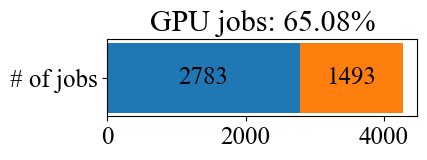

In [3]:
# filter out GPU-only jobs
num_GPU_jobs = len(df_worker_GPU['job_name'].unique())
_, ax = plt.subplots(figsize=(4, 1))

b = ax.barh(["# of jobs"], [num_GPU_jobs])
ax.bar_label(b, label_type="center")
b = ax.barh(["# of jobs"], [num_valid_jobs - num_GPU_jobs], left=num_GPU_jobs)
ax.bar_label(b, label_type="center")
plt.title(f"GPU jobs: {num_GPU_jobs/num_valid_jobs*100:.2f}%")

In [4]:
df_valid = df_worker_GPU

Text(0.5, 1.0, 'Worker GPU usage')

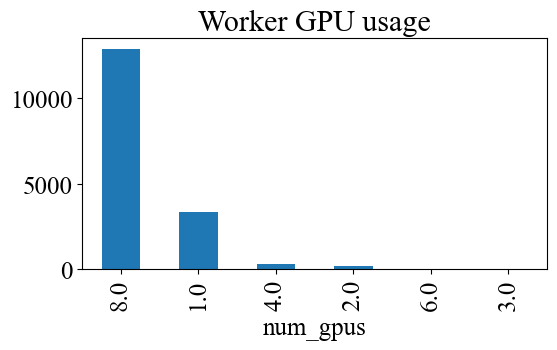

In [5]:
vc = df_valid['num_gpus'].value_counts()
_, ax = plt.subplots(figsize=(6, 3))
vc.plot(kind='bar', ax=ax)
plt.title('Worker GPU usage')


Most workers use all 8 GPUs in a machine.

Text(0.5, 1.0, 'Job GPU usage')

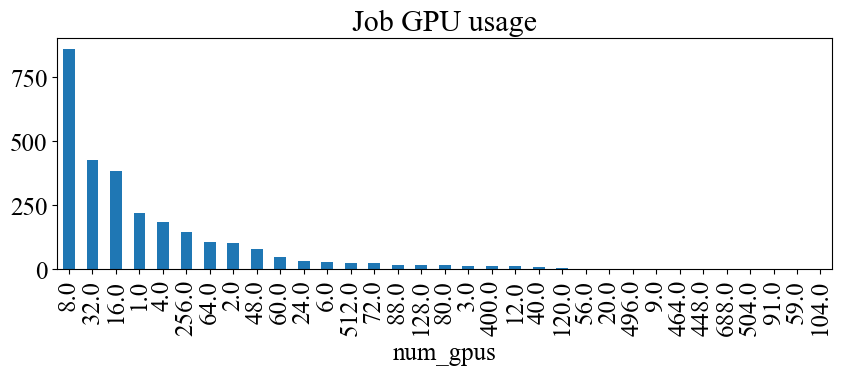

In [6]:
_, ax = plt.subplots(figsize=(10, 3))
vc = df_worker_jobs['num_gpus'].value_counts()
vc.plot(kind='bar', ax=ax)
plt.title("Job GPU usage")

Text(0.5, 1.0, 'Figure 4: Job GPU usage cdf')

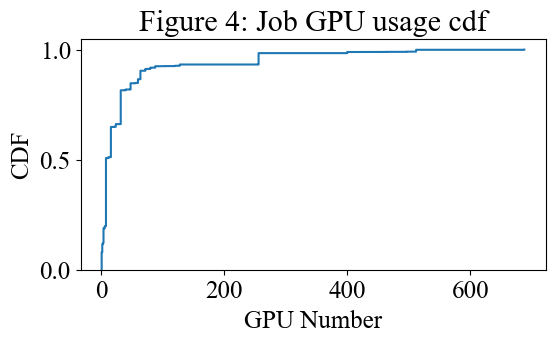

In [7]:
_, ax = plt.subplots(figsize=(6, 3))
ax.ecdf(df_worker_jobs['num_gpus'])
ax.set_ylim(top=1.05)
ax.set_xlabel("GPU Number")
ax.set_ylabel("CDF")
plt.title("Figure 4: Job GPU usage cdf")

Text(0.5, 1.0, 'Figure 5a')

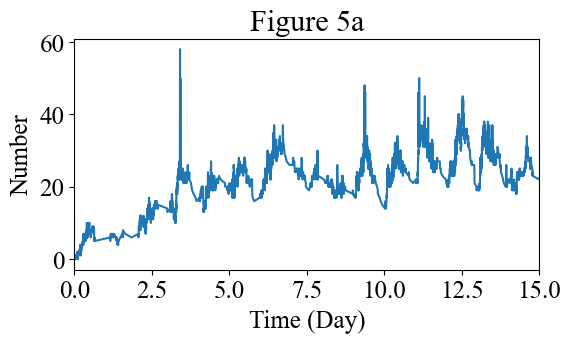

In [8]:
from collections import OrderedDict

def count_jobs_at_each_moment(jobs):
    events = []

    for start, end in jobs:
        events.append((start, 'start'))
        events.append((end, 'end'))

    # Sort events by time, processing end before start at the same time
    events.sort(key=lambda x: (x[0], x[1] == 'start'))

    # Counting jobs over time
    current_active_jobs = 0
    results = {}
    for time, type in events:
        if type == 'start':
            current_active_jobs += 1
        else:
            current_active_jobs -= 1
        results[time] = current_active_jobs
    
    return OrderedDict(sorted(results.items()))

list_tuples = []
for _, row in df_worker_jobs.iterrows():
    list_tuples.append((row['start_time'], row['end_time']))
num_running_jobs_over_time = count_jobs_at_each_moment(list_tuples)
_, ax = plt.subplots(figsize=(6, 3))
times = list(num_running_jobs_over_time.keys())
ax.plot(times, num_running_jobs_over_time.values())
ax.set_xlim((0, 15))
ax.set_xlabel("Time (Day)")
ax.set_ylabel("Number")
plt.title("Figure 5a")

Although the figure is not totally the same as that in the paper, the trend is similar.

Text(0.5, 1.0, 'Figure 5b')

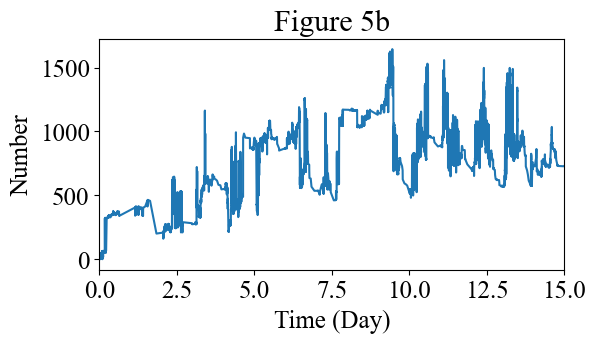

In [9]:
list_tuples = []
for _, row in df_valid.iterrows():
    num_gpus = row['num_gpus']
    for _ in range(int(num_gpus)): 
        list_tuples.append((row['gmt_created'], row['gmt_pod_finished']))
num_running_jobs_over_time = count_jobs_at_each_moment(list_tuples)
_, ax = plt.subplots(figsize=(6, 3))
times = list(num_running_jobs_over_time.keys())
ax.plot(times, num_running_jobs_over_time.values())
ax.set_xlim((0, 15))
ax.set_xlabel("Time (Day)")
ax.set_ylabel("Number")
plt.title("Figure 5b")